In [101]:
import numpy as np
import scipy.io
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
mat1 = scipy.io.loadmat('ANALYSIS PIPELINE/sis_theta_A_W_uni11_100ms.mat')["infected_fraction1"]
mat2 = scipy.io.loadmat('ANALYSIS PIPELINE/sis_theta_A_W_uni12_100ms.mat')["infected_fraction2"]
mat3 = scipy.io.loadmat('ANALYSIS PIPELINE/sis_theta_A_W_uni13_100ms.mat')["infected_fraction3"]
mat4 = scipy.io.loadmat('ANALYSIS PIPELINE/sis_theta_A_W_uni14_100ms.mat')["infected_fraction4"]
mat5 = scipy.io.loadmat('ANALYSIS PIPELINE/sis_theta_A_W_uni15_100ms.mat')["infected_fraction5"]
mat6 = scipy.io.loadmat('ANALYSIS PIPELINE/sis_theta_A_W_uni16_100ms.mat')["infected_fraction6"]
mat7 = scipy.io.loadmat('ANALYSIS PIPELINE/sis_theta_A_W_uni17_100ms.mat')["infected_fraction7"]
mat8 = scipy.io.loadmat('ANALYSIS PIPELINE/sis_theta_A_W_uni18_100ms.mat')["infected_fraction8"]

In [3]:
mat1.shape

(49, 2437)

In [39]:
matrices = [mat1,mat2,mat3,mat4,mat5, mat6, mat7, mat8]

min_nodes = 1000

for mat in matrices:
    min_nodes = min(min_nodes, mat.shape[0])

min_nodes

27

In [40]:
matrices = [mat[:min_nodes] for mat in matrices]

In [41]:
data = []
actual = []

pre, during, post = [], [], []

for mat in matrices:
    pre.extend([vector for vector in mat[:,:250].T])
    during.extend([vector for vector in mat[:,250:-250].T])
    post.extend([vector for vector in mat[:,-250:].T])


In [88]:
x = np.array(pre)
x.shape, len(pre)

((2000, 27), 2000)

In [91]:
data = np.concatenate([np.array(pre), np.array(during), np.array(post)], axis=0)

actual = np.zeros(len(data))

actual[-len(post):] = 1

In [92]:
data.shape

(16549, 27)

In [80]:
from sklearn.cluster import KMeans

labels_pred = KMeans(n_clusters=2, random_state=0, n_init=20).fit_predict(data)

In [81]:
np.unique(labels_pred)

array([0, 1], dtype=int32)

In [82]:
split1 = len(pre)
split2 = len(during)
split3 = len(post)

labels_pre = labels_pred[:split1]
labels_during = labels_pred[split1:split1+split2]
labels_post = labels_pred[-split3:]

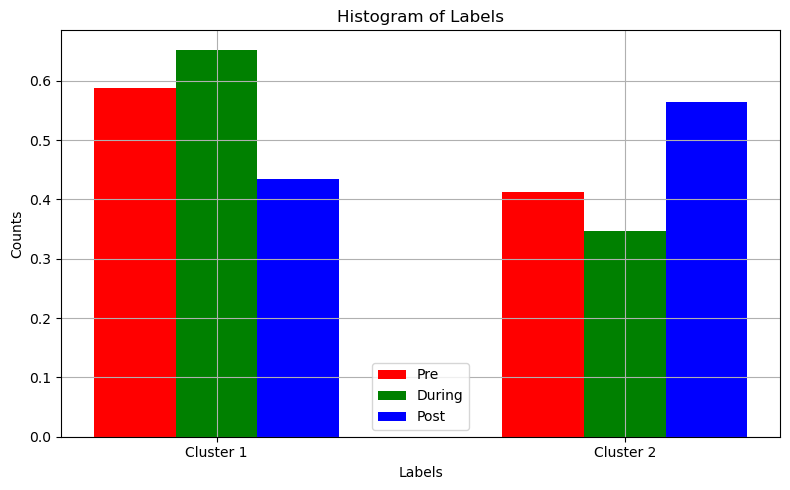

In [87]:
_, count_pre= np.unique(labels_pre, return_counts=True)
_, count_during= np.unique(labels_during, return_counts=True)
_, count_post = np.unique(labels_post, return_counts=True)

count_pre = count_pre / np.sum(count_pre)
count_during = count_during / np.sum(count_during)
count_post = count_post / np.sum(count_post)

# Labels
# labels = ['Label 1', 'Label 2', 'Label 3']
labels = ['Cluster 1', 'Cluster 2']

# Positions for bars
positions = np.arange(len(labels))

# Width of each bar
width = 0.2

# Plot grouped bar chart
plt.figure(figsize=(8, 5))

plt.bar(positions - width, count_pre, width=width, color='r', label='Pre')
plt.bar(positions, count_during, width=width, color='g', label='During')
plt.bar(positions + width, count_post, width=width, color='b', label='Post')

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Histogram of Labels')
plt.xticks(positions, labels)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [108]:
selected_rows_pre = np.random.choice(len(pre), size=1000, replace=False)
selected_rows_during = np.random.choice(len(during), size=1000, replace=False)

indices = np.concatenate((selected_rows_pre, len(pre)+selected_rows_during))

data_0 = data[indices]
data_1 = data[-len(post):]

actual_0 = actual[indices]
actual_1 = actual[-len(post):]

train_data = np.concatenate((data_0, data_1), axis=0)
train_y = np.concatenate((actual_0, actual_1), axis=0)

indices = np.arange(len(train_data))
np.random.shuffle(indices)

train_data = train_data[indices]
train_y = train_y[indices]

print(train_data.shape, train_y.shape)

(4000, 27) (4000,)


In [115]:
# Define a simple binary classifier
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim = 100):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
        # self.linear = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.linear(x)
        x = self.model(x)
        x = self.sigmoid(x)
        return x

# Initialize model, loss, and optimizer
input_dim = train_data.shape[1]  # Input dimension
model = BinaryClassifier(input_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # SGD optimizer

In [116]:
train_data = torch.tensor(train_data).float()
train_y = torch.tensor(train_y).float()

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_94463/2277706040.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_data).float()
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_94463/2277706040.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y).float()


In [121]:
# Training
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()  # Zero gradients
    outputs = model(train_data)  # Forward pass
    loss = criterion(outputs.view(-1), train_y)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.6231
Epoch [20/100], Loss: 0.6231
Epoch [30/100], Loss: 0.6231
Epoch [40/100], Loss: 0.6231
Epoch [50/100], Loss: 0.6231
Epoch [60/100], Loss: 0.6231
Epoch [70/100], Loss: 0.6231
Epoch [80/100], Loss: 0.6231
Epoch [90/100], Loss: 0.6231
Epoch [100/100], Loss: 0.6231


In [120]:
from sklearn.metrics import accuracy_score
with torch.no_grad():
    outputs = model(train_data)  # Forward pass
    predicted_prob = outputs.squeeze()
    predicted = (outputs > 0.5).float().squeeze()
    print(predicted.shape)

acc = accuracy_score(train_y, predicted)
print(acc)

torch.Size([4000])
0.6385
